In [80]:
import hoomd
import numpy as np
from numba import njit
from hoomd import nlist_plugin
from monk import pair as monk_pair
import gsd.hoomd
import pandas as pd
import matplotlib.pyplot as plt

In [91]:
import copy


# @njit
def _neb_force_compute(segments, k, rtags, neb_force, force, pos, N, R1, R2, tau1, tau2, tau):

    for i in range(1, len(segments)-1):
        head = segments[i]
        head_n1 = segments[i-1]
        head_p1 = segments[i+1]

        frame_force = force[head:head+N]  # this should be ok

        for j in range(N):
            R1[j] = pos[rtags[head+j]] - pos[rtags[head_n1+j]]
            R2[j] = pos[rtags[head_p1+j]] - pos[rtags[head+j]]
        norm1 = np.linalg.norm(R1)
        norm2 = np.linalg.norm(R2)
        for j in range(N):
            tau1[j] = R1[j]/norm1
            tau2[j] = R2[j]/norm2
        tau = tau1 + tau2
        tau /= np.linalg.norm(tau)

        x = np.sum(frame_force * tau)
        t = k * np.sum((R2 - R1)* tau)

        nudge_force = t - x
        for j in range(N):
            neb_force[rtags[head+j]] = nudge_force*tau[j]


class NudgedForce(hoomd.md.force.Custom):
    def __init__(self, k: float, segments: np.ndarray, force: hoomd.md.force.Force):
        self._k = k
        self._segments = segments
        self._force = force
        self._N = segments[1] - segments[0]
        self._tau1 = np.zeros((self._N, 3))
        self._tau2 = np.zeros((self._N, 3))
        self._tau = np.zeros((self._N, 3))
        self._R1 = np.zeros((self._N, 3))
        self._R2 = np.zeros((self._N, 3))
        super().__init__(aniso=False)

    def set_forces(self, timestep):
        force = self._force.forces  # doesn't need rtags
        # with self._state.cpu_local_snapshot as snap:
        #     with self.cpu_local_force_arrays as arrays:
        #         _neb_force_compute(self._segments, self._k, snap.particles.rtag._coerce_to_ndarray(),
        #                            arrays.force._coerce_to_ndarray(), force, snap.particles.position._coerce_to_ndarray(),
        #                            self._N, self._R1, self._R2, self._tau1, self._tau2, self._tau)
        plt.hist(np.linalg.norm(force, axis=-1), bins=100),
        # plt.hist(arrays.force._coerce_to_ndarray(), bins=100)
            


class NudgedElasticBand:

    def __init__(self, sim: hoomd.Simulation):
        # if deepcopy:
        #     self.__sim = copy.deepcopy(sim)
        # else:
        self.__sim = sim
        self._setup = False

    def setup(self, initial_snap=None, final_snap=None, n_images=10):

        # get a clean simulation object
        if "_sim" in self.__dict__:
            del self._sim
        self._sim = self.__sim
        sim = self._sim

        integrator = sim.operations.integrator
        # assert isinstance(integrator, hoomd.md.Integrator)
        orig_force = integrator.forces.pop()  # only support single forces atm
        # orig_method = integrator.methods[0]  # probably don't need this

        if initial_snap is None:
            initial_snap = sim.state.get_snapshot()

        if final_snap is None:
            raise ValueError("final_state must be specified")

        N = initial_snap.particles.N
        types = initial_snap.particles.types
        typeid = initial_snap.particles.typeid
        if N != final_snap.particles.N:
            raise ValueError(
                "initial and final states must have the same number of particles")
        if types != final_snap.particles.types:
            raise ValueError(
                "initial and final states must have the same particle types")
        if (typeid != final_snap.particles.typeid).any():
            raise ValueError(
                "initial and final states must have the same particle types")

        pos = np.zeros((n_images + 2, N, 3))
        pos[0] = initial_snap.particles.position
        pos[-1] = final_snap.particles.position
        forces = []
        segments = [0]
        head = N
        for i in range(1, n_images + 1):
            segments.append(head)
            pos[i] = (n_images - i) / n_images * \
                pos[0] + i / n_images * pos[-1]
            head += N
        segments.append(head)
        segments_nlist = [(segments[i], segments[i+1]) for i in range(len(segments)-1)]
        segments = np.array(segments)[:-1] # remove the last element since it's not needed for the force
        neb_nlist = nlist_plugin.nlist.NEBCell(buffer=0.2, segments=segments_nlist)

        orig_force.nlist=neb_nlist
        nudge_force = NudgedForce(1.0, segments, orig_force)

        # create a new snapshot
        snap = sim.state.get_snapshot()
        total_images = n_images + 2
        new_N = N * total_images
        snap.particles.N = new_N
        snap.particles.position[:] = pos.reshape((new_N, 3))
        # snap.particles.types[:] = types
        print(snap.particles.types)
        snap.particles.typeid[:] = np.repeat(typeid, total_images)

        sim.state.set_snapshot(snap)

        integrator.forces = [orig_force, nudge_force]

        self._setup = True

    def run(self, steps):
        if not self._setup:
            raise RuntimeError("setup must be called before run")
        self._sim.run(steps)


In [92]:
test_file = "/media/ian/Data2/monk/mlj-production/workspace/1fd668d1992cea34bb8de5b9cf4bc990/short_runs/temp-0.45/fire_traj.gsd"
test_df = "/media/ian/Data2/monk/mlj-production/workspace/1fd668d1992cea34bb8de5b9cf4bc990/short_runs/temp-0.45/sfs.parquet"
test_traj = gsd.hoomd.open(test_file)

In [93]:
df = pd.read_parquet(test_df)

In [94]:
df[(df["type"] == 0) & (df["frame"] == 0) & (df["phop"] >= 0.2)]

,frame,tag,type,phop,sf
1333,0,1333,0,0.215894,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.034281958, 0.0, 0...."
1799,0,1799,0,0.542279,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.032778833, 0.00295..."
3385,0,3385,0,0.232218,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.018651221, 0.0, 0...."
3401,0,3401,0,0.279602,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.03859187, 0.005574..."
3732,0,3732,0,0.203036,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.012753886, 0.0, 0...."
8776,0,8776,0,0.233670,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.046560094, 0.00224..."
9818,0,9818,0,0.248911,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.025974682, 0.00313..."
13645,0,13645,0,0.237057,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.054570243, 0.00222..."
13742,0,13742,0,0.243434,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.018473662, 0.00530..."
14062,0,14062,0,0.332431,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.005908527, 0...."


In [95]:
cpu = hoomd.device.CPU()
sim = hoomd.Simulation(cpu, seed=0)
sim.create_state_from_gsd(test_file, frame=0)
sim.operations.integrator = hoomd.md.minimize.FIRE(0.001, 1e-3, 0.1, 1e-3)
nlist = hoomd.md.nlist.Cell(buffer=0.3)
force = monk_pair.KA_ModLJ(nlist, 0.0)
sim.operations.integrator.forces.append(force)
# nve = hoomd.md.methods.NVE(hoomd.filter.All())
nve = relaxer = hoomd.md.methods.DisplacementCapped(
    filter=hoomd.filter.All(), maximum_displacement=1e-2)
sim.operations.integrator.methods.append(nve)

neb_compute = NudgedElasticBand(sim)
neb_compute.setup(test_traj[0], test_traj[5], n_images=2)

['A', 'B']


In [96]:
sim.timestep

1470403

**ERROR**: Particle with unique tag 65470 is no longer in the simulation box.

Cartesian coordinates: 
x: 5040.07 y: -18547.2 z: -11792.8
Fractional coordinates: 
f.x: 167.871 f.y: -615.415 f.z: -391.118
Local box lo: (-15.0566, -15.0566, -15.0566)
          hi: (15.0566, 15.0566, 15.0566)


RuntimeError: Error computing cell list

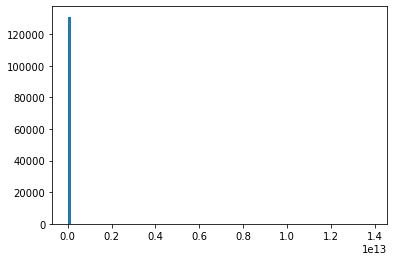

In [97]:
neb_compute.run(1)

In [68]:
sim.timestep

1470403

In [20]:
neb_compute._sim.operations.integrator.forces[1]._k

1.0